# Step 4: Model Building

The data is ready for model training.

There are two primary steps in this process:
1) 
2) 

Thoughts: 
- I need to find the list price just before purchase for all recently sold properties. This list price should be used for calculating the price/sqft and should also be the target variable for training. Once the model has been trained, the predicted price should be compared to the sold price. Though, its likely the listed price just before sale is quite close to the sold price and thus, might not make a huge difference. 

Concerns: 
- I am concerned that the models are getting "future" data somehow... All these models perform better than 92% on training, testing, and live data...
- It is possible the price/sqft value is predicting the future. See "thoughts" above.

---

In [1]:
'''
Import libraries
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from itertools import cycle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from scipy.stats import ks_2samp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

pd.options.display.max_columns = None

In [2]:
'''
Build helper functions for code cleanliness
'''

# https://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Find best random state that minimizes the K-S distance:
# Use that min value for random state in the "actual" split below.
def minKS_tts(X, y, test_size):
    n_features = X.shape[1]
    n_tries = 100
    result = []
    for random_state in range(n_tries):
        X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=random_state)
        distances = list(map(lambda i : ks_2samp(X_train[:,i],X_test[:,i]).statistic,range(n_features)))
        result.append((random_state,max(distances)))
    result.sort(key = lambda x : x[1])
    return result[0][0]

# Matches 'series' column data statistical distribution to 'reference' column's statistical distribution.
# Uses ECDF
def match_ecdf(series, reference):
    sorted_series = np.sort(series, kind='mergesort')
    sorted_reference = np.sort(reference, kind='mergesort')
    ecdf_series = np.linspace(0, 1, len(series), endpoint=False)
    ecdf_reference = np.linspace(0, 1, len(reference), endpoint=False)
    matched_values = np.interp(ecdf_series, ecdf_reference, sorted_reference)
    matched_series = np.interp(sorted_series, sorted_series, matched_values)
    return matched_series


# Create function that determines optimal value of 'K' for KMeans clustering
def find_optimal_k(X, max_k=10):
    '''
    Find the optimal number of clusters (k) using the Elbow Method.

    ## Parameters:
    - X: Input data.
    - max_k: Maximum number of clusters to consider.

    ## Returns:
    - optimal_k: The optimal number of clusters.
    - inertia_values: List of inertia values for each k.
    '''

    # Initialize an empty list to store the sum of squared distances (inertia) for each k
    inertia_values = []

    # Define a range of k values (number of clusters)
    k_values = range(1, max_k + 1)

    # Iterate over each k value and fit the KMeans model
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    # Find the optimal k using the Elbow Method (simple heuristic: look for the "elbow" in the plot)
    optimal_k = np.argmin(np.diff(inertia_values)) + 1

    # Plot the Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.grid(True)
    plt.show()

    return optimal_k, inertia_values

In [3]:
'''
User Variables
'''

removeOutliers = False # If true, outliers will be removed. <-- Currently not working since DataCleanPrep removes outliers inplace.

In [4]:
'''
Read in csv files.
'''

df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold.drop(columns=['dateSold'], inplace=True)

df_forSale.rename(columns={'listPrice':'price'}, inplace=True)
df_recentlySold.rename(columns={'soldPrice':'price'}, inplace=True)

if removeOutliers:
    df_forSale = df_forSale.loc[df_forSale['Outlier']==0]
    df_recentlySold = df_recentlySold.loc[df_recentlySold['Outlier']==0]

# Build, Train, and Test K-Means Clustering Model.

In [5]:
'''
Drop unnecessary features.
'''

# Setting Target Variable for Regression Models
y_forSale = df_forSale['price']
y_recentlySold = df_recentlySold['price']

# Setting features for K-Means Clustering. Regression dataframes will be set further down.
X_forSale = df_forSale.copy()
X_recentlySold = df_recentlySold.copy()

X_forSale.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)
X_recentlySold.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)

# df_forSale.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)
# df_recentlySold.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)

# Setting features for K-Means Clustering. Regression dataframes will be set further down.
# X_forSale = df_forSale.copy()
# X_recentlySold = df_recentlySold.copy()

df_forSale_cols = X_forSale.columns
df_recentlySold_cols = X_recentlySold.columns

In [6]:
# '''
# Scale Data for K-Means
# '''

# KM_feats = ['lotAreaValue','livingAreaValue','bathrooms','bedrooms','schoolMaxRating','schoolMinDistance','zipcode','resoFacts.taxAnnualAmount']

# rs = StandardScaler()
# KM_recentlySold = rs.fit_transform(X_recentlySold[KM_feats])
# KM_forSale = rs.transform(X_forSale[KM_feats])

# KM_recentlySold = pd.DataFrame(data=KM_recentlySold, columns=KM_feats)
# KM_forSale = pd.DataFrame(data=KM_forSale, columns=KM_feats)

In [7]:
# '''
# Find best KMeans features and n_clusters
# '''

# kmeans_kwargs = {"init": "random","n_init": 20,"max_iter": 1000,"random_state": 1984}
# maxvars=3
# kmin=3
# kmax=4

# cols=list(KM_recentlySold.columns)

# if len(cols) < (kmax-kmin+1)*maxvars:
#     raise ValueError('Too few features. (kmax-kmin+1)*maxvars >= len(features)')

# results_for_each_k=[]
# vars_for_each_k={}

# for k in range(kmin,kmax+1):
#     selected_variables=[]
#     while(len(selected_variables)<maxvars):
#         results=[]
#         for col in cols:
#             scols=[]
#             scols.extend(selected_variables)
#             scols.append(col)
#             kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#             kmeans.fit(KM_recentlySold[scols])
#             results.append(silhouette_score(KM_recentlySold[scols], kmeans.predict(KM_recentlySold[scols])))
#         selected_var=cols[np.argmax(results)]
#         selected_variables.append(selected_var)
#         cols.remove(selected_var)
#     results_for_each_k.append(max(results))
#     vars_for_each_k[k]=selected_variables

# best_k=np.argmax(results_for_each_k)+kmin
# #you can also force a value for k
# # best_k=3
# selected_variables=vars_for_each_k[best_k]
# kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
# kmeans.fit(KM_recentlySold[selected_variables])
# clusters=kmeans.predict(KM_recentlySold[selected_variables])

# print(f'Best k: {best_k}')
# print(f'Silhouette Score: {results_for_each_k[kmin-best_k]}')
# print(f'Best Features: {selected_variables}')

In [8]:
# df_recentlySold.columns

In [9]:
# '''
# KMeans to find best groups -- This clustering model needs to have some feature engineering done to it. Not currently looking that great!
# '''

# km = KMeans(n_clusters=best_k, **kmeans_kwargs)
# km.fit(KM_recentlySold[selected_variables])
# recentlySoldLabels = km.labels_
# forSaleLabels = km.predict(KM_forSale[selected_variables])

# score = silhouette_score(KM_recentlySold[selected_variables], recentlySoldLabels)
# print(f'Silhouette score on recentlySold Data: {score}')
# score = silhouette_score(KM_forSale[selected_variables], forSaleLabels)
# print(f'Silhouette score on forSale Data: {score}')


# # df_forSale.insert(25, 'KMeans', forSaleLabels, True)
# # df_recentlySold.insert(25, 'KMeans', recentlySoldLabels, True)

# '''
# Plotting Below
# '''

# label2Print = [0,1,2]
# keys = []
# value = []
# for i in range(best_k):
#     keys.append(i)
#     value.append(f'Cluster {i}')
# labels=dict(zip(keys,value))

# colors = cycle(cm.tab10.colors)
# plt.figure()
# # Plot recentlySold Clusters
# for i in range(best_k):
#     if i in label2Print:
#         color = next(colors)
#         idx = recentlySoldLabels==i
#         plt.scatter(df_recentlySold.iloc[idx,10], df_recentlySold.iloc[idx,2], color=color, label=labels[i], s=5, alpha=1)
# # plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
# plt.xlabel('Lot Area Value')
# plt.ylabel('Price')
# plt.title(f'KMeans - n_Cluster: {best_k}')
# plt.legend()
# plt.show()

# colors = cycle(cm.tab10.colors)
# plt.figure(figsize=[8,8])
# # Plot recentlySold Clusters
# for i in range(best_k):
#     if i in label2Print:
#         color = next(colors)
#         idx = recentlySoldLabels==i
#         plt.scatter(df_recentlySold.iloc[idx,12], df_recentlySold.iloc[idx,15], color=color, label=labels[i], s=5, alpha=1)
# # plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
# plt.xlabel('Lot Area Value')
# plt.ylabel('Price')
# plt.xlim([-81, -80])
# plt.title(f'KMeans - n_Cluster: {best_k}')
# plt.legend()
# plt.show()

# colors = cycle(cm.tab10.colors)
# plt.figure()
# # Plot recentlySold Clusters
# for i in range(best_k):
#     if i in label2Print:
#         color = next(colors)
#         idx = forSaleLabels==i
#         plt.scatter(df_forSale.iloc[idx,10], df_forSale.iloc[idx,2], color=color, label=labels[i], s=5, alpha=1)
# # plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
# plt.xlabel('Lot Area Value')
# plt.ylabel('Price')
# # plt.xlim([0, 300000])
# plt.title(f'KMeans - n_Cluster: {best_k}')
# plt.legend()
# plt.show()

# colors = cycle(cm.tab10.colors)
# plt.figure()
# # Plot recentlySold Clusters
# for i in range(best_k):
#     if i in label2Print:
#         color = next(colors)
#         idx = forSaleLabels==i
#         plt.scatter(df_forSale.iloc[idx,12], df_forSale.iloc[idx,15], color=color, label=labels[i], s=5, alpha=1)
# # plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
# plt.xlabel('Lot Area Value')
# plt.ylabel('Price')
# plt.title(f'KMeans - n_Cluster: {best_k}')
# plt.legend()
# plt.show()

# Build, Train, Test, and Validate Regression Models on recentlySold Dataset

In [10]:
'''
Rebuiding dataframes for regression models
Drop multicollineated features
Drop price/sqft -- Since target is price, anything directly proportional to it needs to be removed.
https://www.kaggle.com/code/erick5/predicting-house-prices-with-machine-learning/notebook
'''

dropThese = ['zipcode','latitude'] + ['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow']


X_forSale = df_forSale.drop(columns=['price'])
X_recentlySold = df_recentlySold.drop(columns=['price'])

X_forSale.drop(columns=dropThese, inplace=True)
X_recentlySold.drop(columns=dropThese, inplace=True)

# df_forSale.drop(columns=dropThese, inplace=True)
# df_recentlySold.drop(columns=dropThese, inplace=True)

# X_forSale = df_forSale.drop(columns=['price'])
# X_recentlySold = df_recentlySold.drop(columns=['price'])

In [11]:
'''
Creating variables for validation matrix at the end.
'''

MODEL = []

Training_R2 = []
ATraining_R2 = []
MAE = []
MAPE = []

Testing_R2 = []
ATesting_R2 = []
tMAE = []
tMAPE = []

Execution_R2 = []
AExecution_R2 = []
eMAE = []
eMAPE = []


In [12]:
'''
Split and scale the data.
'''

X_train, X_test, y_train, y_test = train_test_split(X_recentlySold, y_recentlySold, test_size=0.3, random_state=42)

# Feature Scaling
'''
- DO NOT APPLY SCALER TO DUMMY/BINARY/BOOL VARIABLES!!! FIX THIS NOW!
- GET RID OF ZIPCODE AND REPLACE WITH VALUES SUCH AS POPULATION, AVERAGE INCOME, AVERAGE FAMILY SIZE, ETC.
'''

scaler_x = RobustScaler()
X_train.iloc[:,0:11] = scaler_x.fit_transform(X_train.iloc[:,0:11]) # Make sure no dummy features are present here.
X_test.iloc[:,0:11] = scaler_x.transform(X_test.iloc[:,0:11])
X_forSale.iloc[:,0:11] = scaler_x.transform(X_forSale.iloc[:,0:11])

'''Currently not working'''
# y_train = y_train.values
# y_test = y_test.values
# y_forSale = y_forSale.values
# scaler_y = RobustScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(len(y_train), 1))
# y_test = scaler_y.transform(y_test.reshape(len(y_test), 1))
# y_forSale = scaler_y.transform(y_forSale.reshape(len(y_forSale), 1))

'Currently not working'

Tuned Hyperparameters:  {'fit_intercept': True}

Training Metrics:
Training R_Squared:  0.7663624272715222
MAE:  0.13583450341759418
MAPE:  1.0618208784287797
Adjusted R2 Score:  0.7627355386178201

Test Metrics:
Testing R_Squared:  0.7492975128818222
MAE:  0.14560507050553753
MAPE:  1.1376977228145009
Adjusted R2 Score:  0.7400247241854538



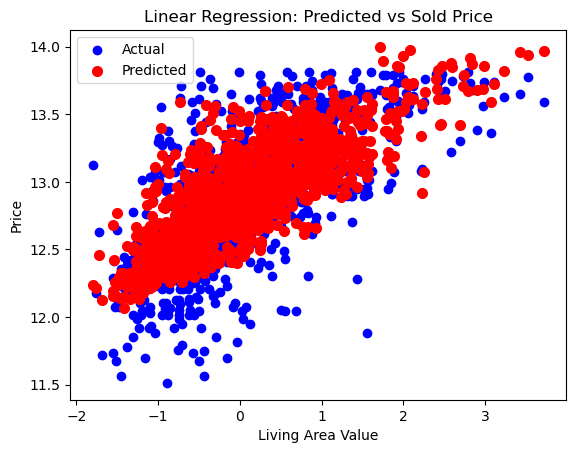

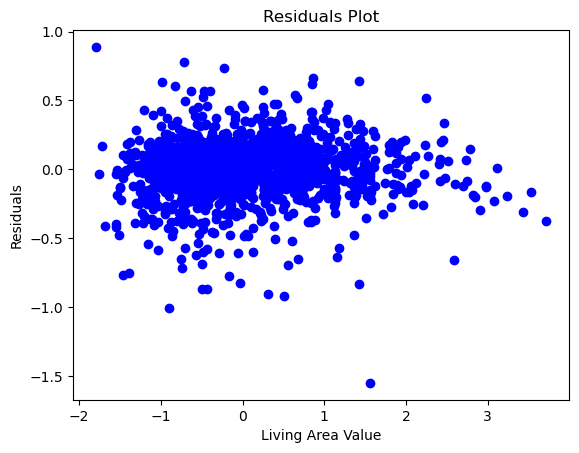

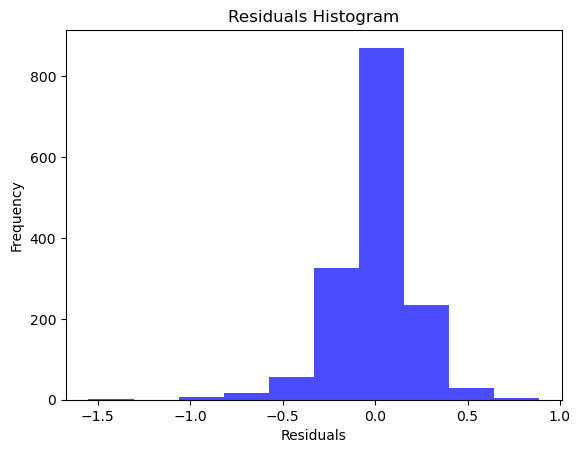

In [13]:
'''
Build, train, test, and validate a LinearRegression() model
'''

MODEL.append('Linear Regression')

# Build, train, and test the model
parameters = {'fit_intercept':[True, False]}
lr = LinearRegression()
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
linReg = GridSearchCV(estimator=lr, param_grid=parameters, cv=rkf, scoring='r2')
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)



# Validate the model
print("Tuned Hyperparameters: ",linReg.best_params_)
print('')

print('Training Metrics:')
score_lr = linReg.score(X_train, y_train)
print("Training R_Squared: ", score_lr)
Training_R2.append(score_lr)
score_lr = mean_absolute_error(y_train, linReg.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, linReg.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
score_lr = r2_score(y_train, linReg.predict(X_train))
n = len(y_train)
k = X_train.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATraining_R2.append(score_lr)
print('')

print('Test Metrics:')
score_lr = linReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATesting_R2.append(score_lr)
print('')

# Visualize the results
plt.scatter(X_test['livingAreaValue'].values, y_test, color='blue', label='Actual')
plt.scatter(X_test['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('Linear Regression: Predicted vs Sold Price')
plt.legend()
plt.show()

# Plot errors
residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(X_test['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

del residuals

Execution Metrics:
Execution R_Squared:  1.0
MAE:  0.13684888894259278
MAPE:  1.0512183063561034
Adjusted R2 Score:  0.7365501057093649



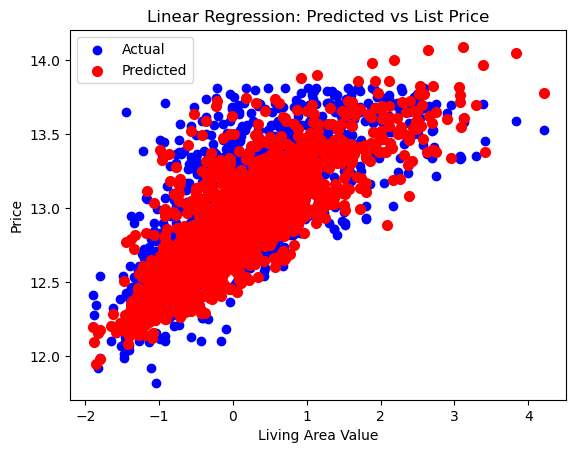

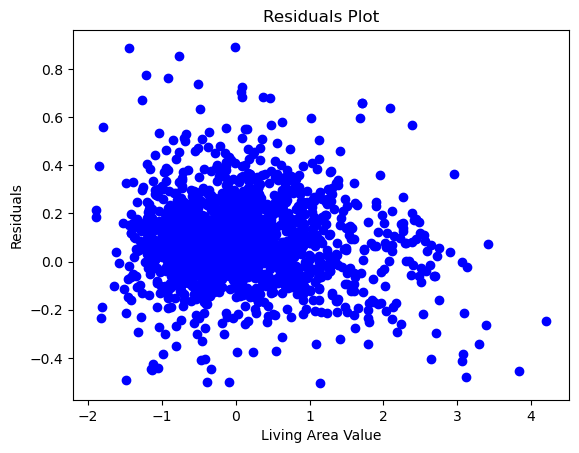

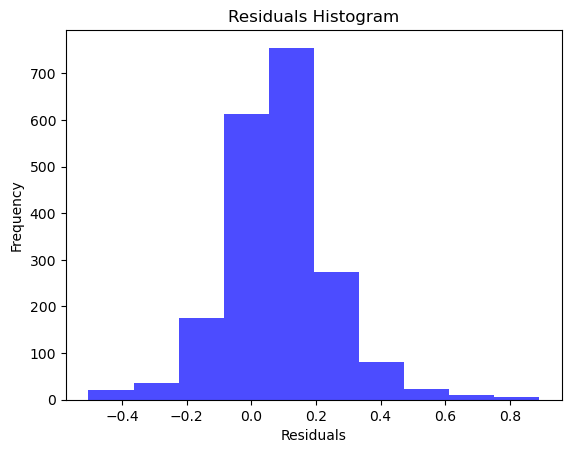

In [14]:
'''
Run LinearRegresion() Model on forSale Data
'''

y_pred = linReg.predict(X_forSale)

# Adding predicted price and price difference to dataframe
df_forSale['predPrice_linear'] = y_pred
df_forSale['priceDiff_linear'] = df_forSale['predPrice_linear'] - df_forSale['price']


# Validate the model
print('Execution Metrics:')
score_lr = linReg.score(X_forSale, y_pred)
print("Execution R_Squared: ", score_lr)
Execution_R2.append(score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
eMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
eMAPE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
AExecution_R2.append(score_lr)
print('')

# Visualize the results
plt.scatter(X_forSale['livingAreaValue'].values, y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('Linear Regression: Predicted vs List Price')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Tuned Hyperparameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Estimator:  RandomForestRegressor(n_estimators=500, random_state=42)

Training Metrics:
Testing R_Squared:  0.9679480193705292
MAE:  0.04835035031393922
MAPE:  0.37827397702065807
Adjusted R2 Score:  0.9674504582825753

Test Metrics:
Testing R_Squared:  0.7550399346643232
MAE:  0.13670010501670368
MAPE:  1.0699326570779761
Adjusted R2 Score:  0.7459795422006633



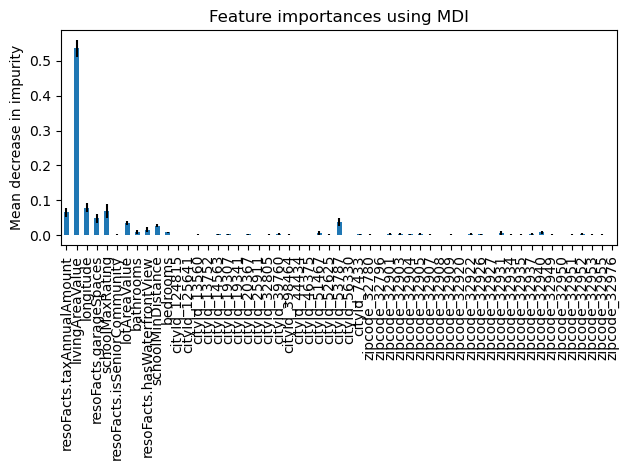

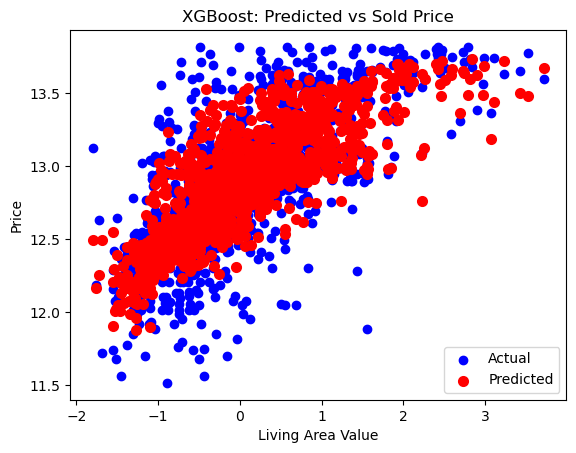

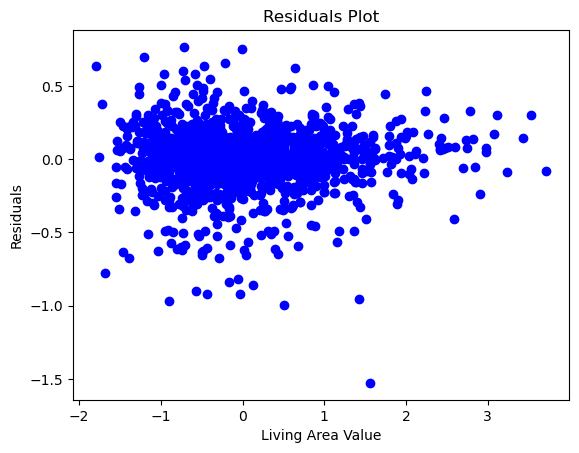

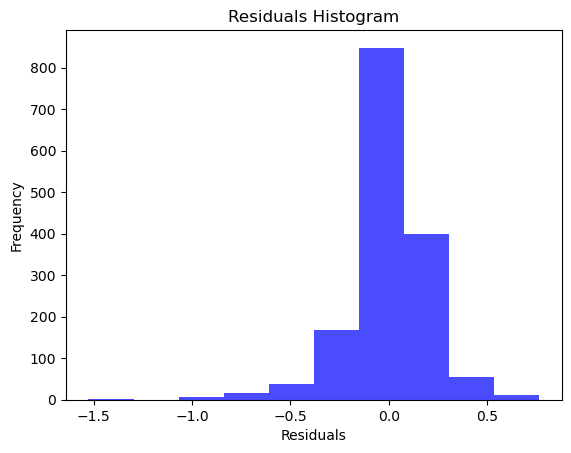

In [15]:
'''
Build, train, test, and validate a RandomForest() model
'''

MODEL.append('Random Forest')

# Build, train, and test the model
# parameters = {
#     'n_estimators': [100, 150, 300, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 3, 5],
#     'bootstrap': [True, False]
# }
# {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [500]}
parameters = {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [500]}

rf = RandomForestRegressor(random_state=42)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
randFor = GridSearchCV(estimator=rf, param_grid=parameters, cv=rkf, scoring='r2', n_jobs=-1)
randFor.fit(X_train, y_train)
best_randFor = randFor.best_estimator_
y_pred = best_randFor.predict(X_test)

# Save copy for ensemble model below
y_pred_RF = y_pred.copy()


# Validate the model
print("Tuned Hyperparameters: ",randFor.best_params_)
print("Best Estimator: ",randFor.best_estimator_)
print('')

print('Training Metrics:')
score_lr = randFor.score(X_train, y_train)
print("Testing R_Squared: ", score_lr)
Training_R2.append(score_lr)
score_lr = mean_absolute_error(y_train, best_randFor.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, best_randFor.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
score_lr = r2_score(y_train, best_randFor.predict(X_train))
n = len(y_train)
k = X_train.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATraining_R2.append(score_lr)
print('')

print('Test Metrics:')
score_lr = randFor.score(X_test, y_test)
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATesting_R2.append(score_lr)
print('')

# Plot feature importance
importances = best_randFor.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_randFor.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_recentlySold.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Visualize the results
plt.scatter(X_test['livingAreaValue'].values, y_test, color='blue', label='Actual')
plt.scatter(X_test['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('XGBoost: Predicted vs Sold Price')
plt.legend()
plt.show()

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Test Metrics:
Testing R_Squared:  1.0
MAE:  0.13356321034531762
MAPE:  1.0267988975698144
Adjusted R2 Score:  0.7163852852169653



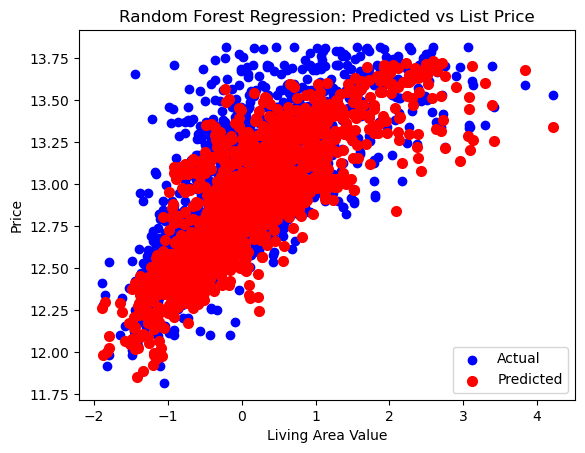

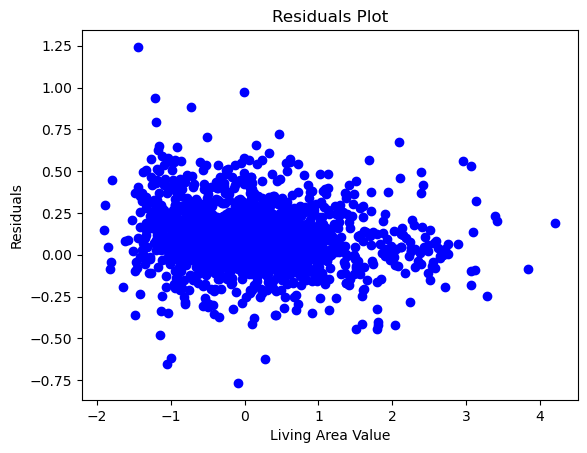

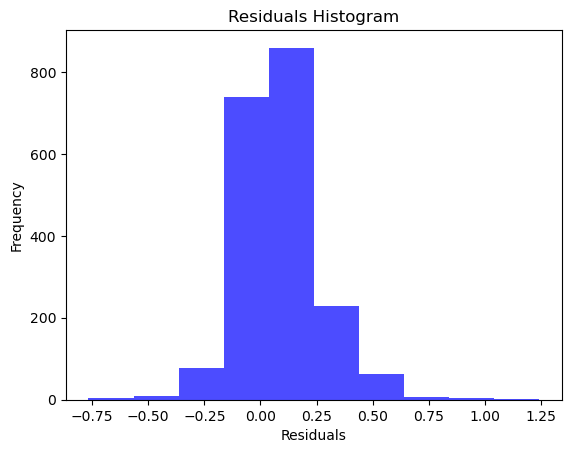

In [16]:
'''
Run RandomForest() Model on forSale Data
'''

y_pred = best_randFor.predict(X_forSale)

# Adding predicted price and price difference to dataframe
df_forSale['predPrice_RandFor'] = y_pred
df_forSale['priceDiff_RandFor'] = df_forSale['predPrice_RandFor'] - df_forSale['price']

# Validating the model
print('Test Metrics:')
score_lr = best_randFor.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Execution_R2.append(score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
eMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
eMAPE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
AExecution_R2.append(score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale['livingAreaValue'].values, y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('Random Forest Regression: Predicted vs List Price')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Tuned Hyperparameters:  {'alpha': 2, 'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.8}
Best Estimator:  XGBRegressor(alpha=2, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=3, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None, ...)

Training Metrics:
Testing R_Squared:  0.8568613230774007
Scatter Index: 

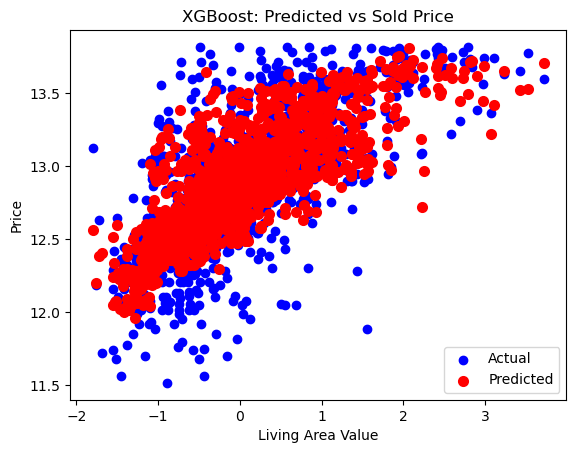

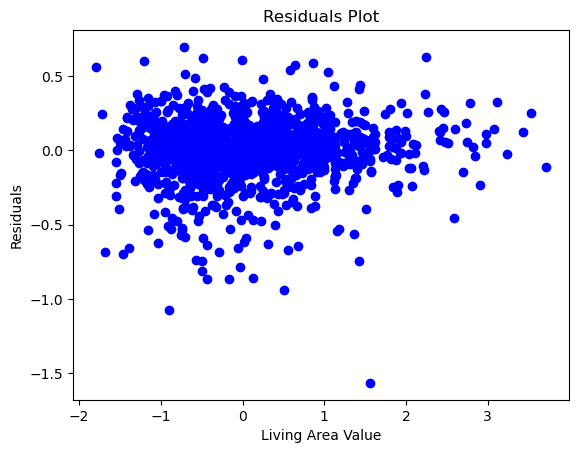

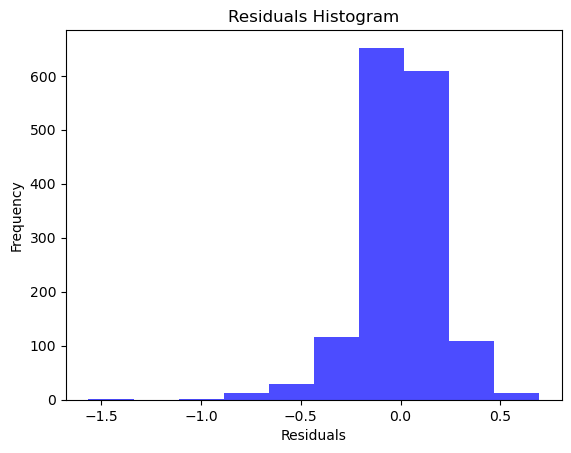

In [17]:
'''
Build, train, test, and validate a XGBoost() model
'''
MODEL.append('XGBoost')

# Build, train, and test the model
# parameters = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.1, 0.2, 0.3, 0.4],
#     'subsample': [0.5, 0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0, 0.1, 0.2], 
#     'booster': ['gbtree'],
#     'lambda': [0, 1, 2, 3],
#     'alpha': [0, 1, 2, 3]
# }

parameters = {'alpha': [2], 'booster': ['gbtree'], 'colsample_bytree': [0.8], 'gamma': [0], 'lambda': [3], 'learning_rate': [0.1], 'max_depth': [5],
              'min_child_weight': [5], 'n_estimators': [150], 'subsample': [0.8]}

xg = XGBRegressor(objective='reg:squarederror', random_state=42)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
boost = GridSearchCV(estimator=xg, param_grid=parameters, cv=rkf, scoring='r2', n_jobs=-1)
boost.fit(X_train, y_train)
best_xgb_model = boost.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Save copy for ensemble model below
y_pred_XGB = y_pred.copy()


# Validate the model
print("Tuned Hyperparameters: ",boost.best_params_)
print("Best Estimator: ",boost.best_estimator_)
print('')

print('Training Metrics:')
score_lr = boost.score(X_train, y_train) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Training_R2.append(score_lr)
score_lr = np.sqrt(mean_squared_error(y_train, best_xgb_model.predict(X_train)))
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_train, best_xgb_model.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, best_xgb_model.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
score_lr = r2_score(y_train, best_xgb_model.predict(X_train))
n = len(y_train)
k = X_train.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATraining_R2.append(score_lr)
print('')

print('Test Metrics:')
score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = np.sqrt(mean_squared_error(y_test, best_xgb_model.predict(X_test)))
score_lr = score_lr/np.mean(y_test) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATesting_R2.append(score_lr)
print('')

# Visualize the results
plt.scatter(X_test['livingAreaValue'].values, y_test, color='blue', label='Actual')
plt.scatter(X_test['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('XGBoost: Predicted vs Sold Price')
plt.legend()
plt.show()

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Test Metrics:
Testing R_Squared:  1.0
Scatter Index:  0.013516344065792165
MAE:  0.12826664324043666
MAPE:  0.9863457345223512
Adjusted R2 Score:  0.7583854945127406



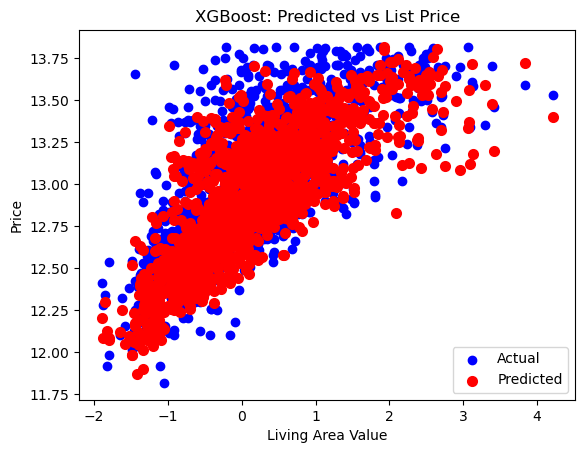

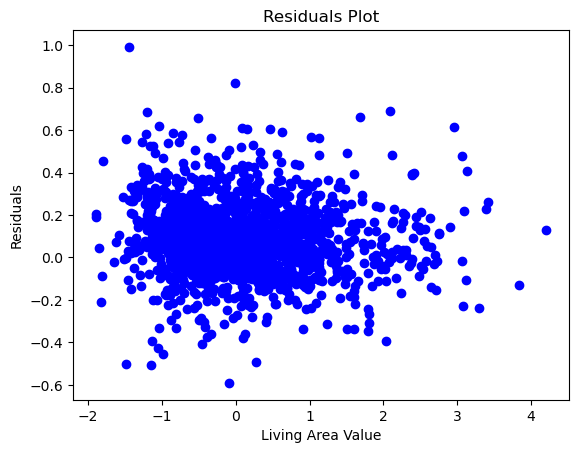

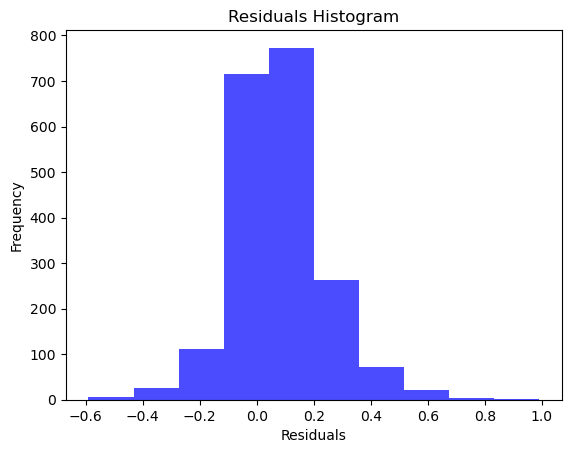

In [18]:
'''
Run XGBoost() Model on forSale Data
'''

y_pred = best_xgb_model.predict(X_forSale)

# Adding predicted price and price difference to dataframe
df_forSale['predPrice_XGBoost'] = y_pred
df_forSale['priceDiff_XGBoost'] = df_forSale['predPrice_XGBoost'] - df_forSale['price']

# Validating the model
print('Test Metrics:')
score_lr = best_xgb_model.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Execution_R2.append(score_lr)
score_lr = np.sqrt(mean_squared_error(y_forSale, best_xgb_model.predict(X_forSale)))
score_lr = score_lr/np.mean(y_forSale) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
eMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
eMAPE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
AExecution_R2.append(score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale['livingAreaValue'].values, y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('XGBoost: Predicted vs List Price')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Test Metrics:
Testing R_Squared:  0.7753191232523569
Scatter Index:  0.015182383108828223
MAE:  0.13247944424166347
MAPE:  1.037343469274461
Adjusted R2 Score:  0.7650584241895979



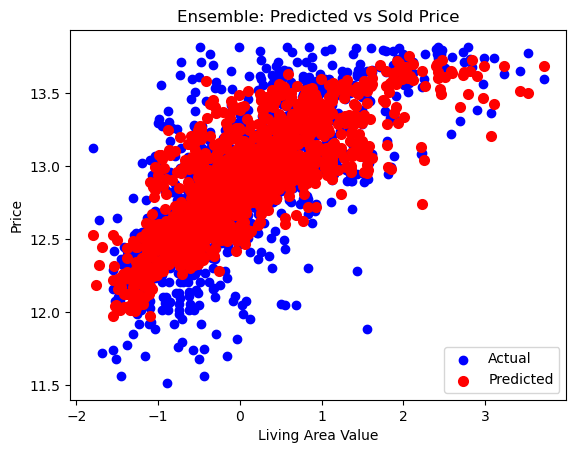

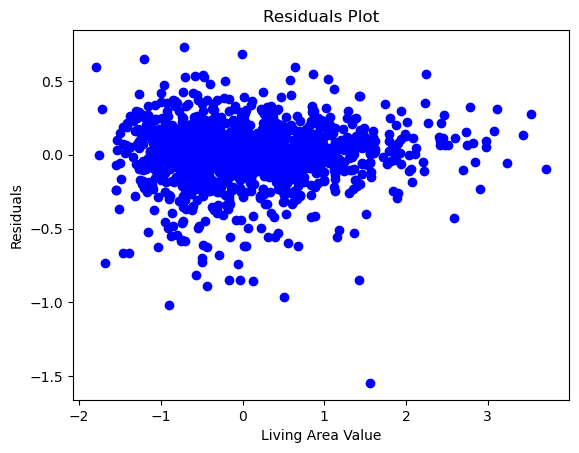

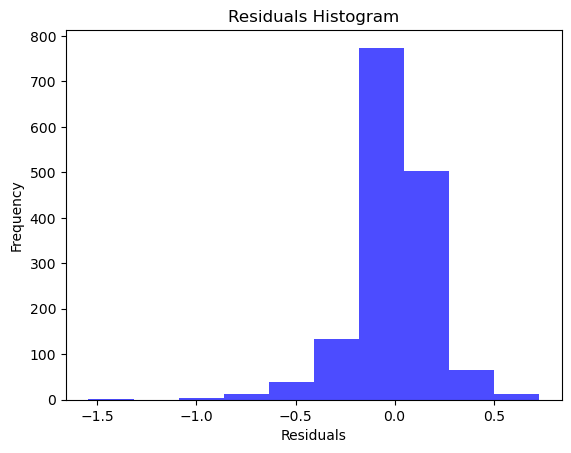

In [19]:
'''
Create Ensemble Model from RandomForest and XGBoost
'''
MODEL.append('Ensemble')

y_pred = (y_pred_RF + y_pred_XGB) / 2



Training_R2.append(None)
MAE.append(None)
MAPE.append(None)
ATraining_R2.append(None)


print('Test Metrics:')
score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = np.sqrt(mean_squared_error(y_test, y_pred))
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
ATesting_R2.append(score_lr)
print('')

# Visualize the results
plt.scatter(X_test['livingAreaValue'].values, y_test, color='blue', label='Actual')
plt.scatter(X_test['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('Ensemble: Predicted vs Sold Price')
plt.legend()
plt.show()

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Execution Metrics:
Scatter Index:  0.013879796627645956
MAE:  0.12843784015186904
MAPE:  0.9873526502941857
Adjusted R2 Score:  0.7478283009066213



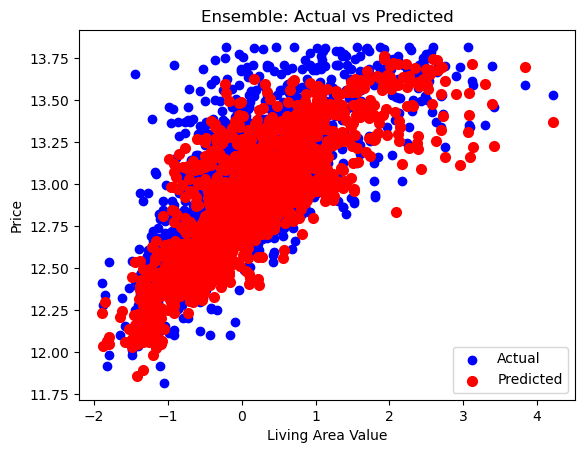

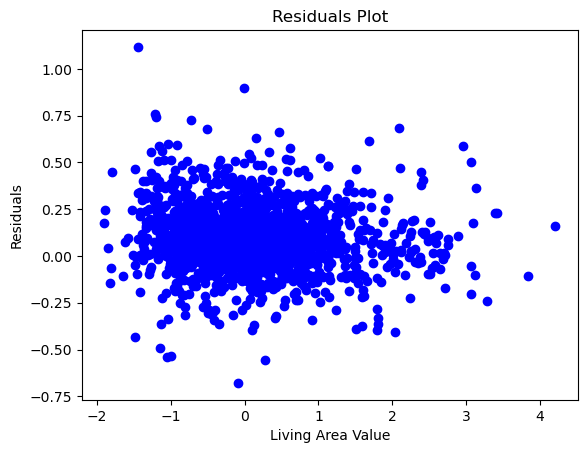

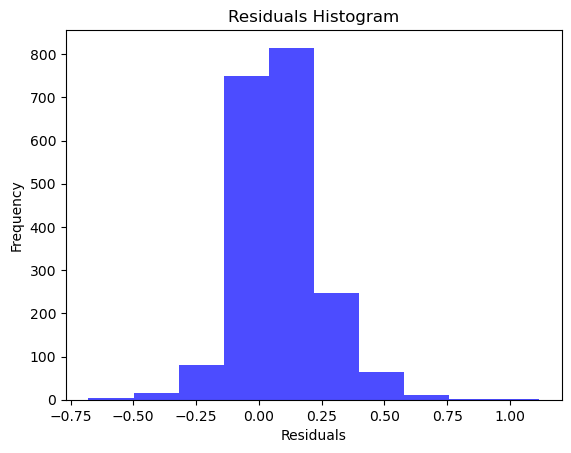

In [20]:
'''
Run Ensemble Model on forSale Data
'''


y_pred = (best_randFor.predict(X_forSale) + best_xgb_model.predict(X_forSale)) / 2
# y_pred = best_xgb_model.predict(X_forSale)


# Adding predicted price and price difference to dataframe
df_forSale['predPrice_ensemble'] = y_pred
df_forSale['priceDiff_ensemble'] = df_forSale['predPrice_ensemble'] - df_forSale['price']


print('Execution Metrics:')
# score_lr = best_xgb_model.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
Execution_R2.append(None)
score_lr = np.sqrt(mean_squared_error(y_forSale, y_pred))
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
eMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
eMAPE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
AExecution_R2.append(score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale['livingAreaValue'].values, y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale['livingAreaValue'].values, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Living Area Value')
plt.ylabel('Price')
plt.title('Ensemble: Actual vs Predicted')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale['livingAreaValue'].values, residuals, color='blue', marker='o')
plt.xlabel('Living Area Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

In [21]:
df_results = pd.DataFrame(dict({'Model':MODEL, 'Training R2':Training_R2, 'Adjusted Training R2': ATraining_R2, 'MAE':MAE, 'MAPE':MAPE,
                                'Testing R2':Testing_R2, 'Adjusted Testing R2':ATesting_R2, 'tMAE':tMAE, 'tMAPE':tMAPE,
                                'Execution R2':Execution_R2, 'Adj. Execution R2':AExecution_R2, 'eMAE':eMAE, 'eMAPE':eMAPE}))

display(df_results)

,Model,Training R2,Adjusted Training R2,MAE,MAPE,Testing R2,Adjusted Testing R2,tMAE,tMAPE,Execution R2,Adj. Execution R2,eMAE,eMAPE
0,Linear Regression,0.766362,0.762736,0.135835,1.061821,0.749298,0.740025,0.145605,1.137698,1.0,0.736550,0.136849,1.051218
1,Random Forest,0.967948,0.967450,0.048350,0.378274,0.755040,0.745980,0.136700,1.069933,1.0,0.716385,0.133563,1.026799
2,XGBoost,0.856861,0.854639,0.105195,0.824371,0.775319,0.767009,0.133927,1.048840,1.0,0.758385,0.128267,0.986346
3,Ensemble,NaN,NaN,NaN,NaN,0.775319,0.765058,0.132479,1.037343,NaN,0.747828,0.128438,0.987353


In [22]:
# Export dataframe to csv
df_forSale.to_csv('final_forSale_data.csv', sep=',', index=True, encoding='utf-8')

---
End of section.
## <pre><-- Previous: EDA                                               Next: Data Visualization --></pre>